In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [28]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder, StandardScaler,  MinMaxScaler, FunctionTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor

from sklearn.metrics import mean_absolute_error
import xgboost as xgb
#import lightgbm as lgb

## 1. Global parameters

In [3]:
features_dir = '../data/01_raw/dengue_features_train.csv'
labels_dir = '../data/01_raw/dengue_labels_train.csv'
test_dir = '../data/01_raw/dengue_features_test.csv'

#logged = True

test_output_dir = 'output.csv'


## 2. Building blocks functions

In [4]:
def get_train_data(features_dir, labels_dir):
    """ 
    Input:
        str to csv with train features and labels
        drop: to drop NaNs from feature columns.

    Output:
         X, y
    
    """
    features = pd.read_csv(features_dir)
    labels = pd.read_csv(labels_dir)

    data = features.merge(labels)
    
    X = data.drop(columns=['total_cases'])
    y = data.loc[:,'total_cases']
    print("Loading of training data finished.\n")
        
    return data, X, y

In [5]:
data, X, y = get_train_data(features_dir, labels_dir)
data

Loading of training data finished.



,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,iq,2010,21,2010-05-28,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,...,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0,5
1452,iq,2010,22,2010-06-04,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,...,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6,8
1453,iq,2010,23,2010-06-11,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,...,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4,1
1454,iq,2010,24,2010-06-18,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,...,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0,1


In [6]:
X

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,iq,2010,21,2010-05-28,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,...,45.00,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0
1452,iq,2010,22,2010-06-04,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,...,207.10,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6
1453,iq,2010,23,2010-06-11,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,...,50.60,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4
1454,iq,2010,24,2010-06-18,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,...,62.33,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0


In [7]:
y

0       4
1       5
2       4
3       3
4       6
       ..
1451    5
1452    8
1453    1
1454    1
1455    4
Name: total_cases, Length: 1456, dtype: int64

In [8]:
def get_preprocessed_X(X, time_column='week_start_date', format='%Y-%m-%d'):
    
    # Timed features.
    X_new = X.copy()
    X_new[time_column] = pd.to_datetime(X_new[time_column], format=format)
 
    X_new['year'] =  X_new[time_column].apply(lambda x: x.year)
    X_new.loc[:,'month'] = X_new[time_column].apply(lambda x: x.month)
    X_new.loc[:,'dayofyear'] = X_new[time_column].apply(lambda x: x.dayofyear)
    X_new['weekofyear'] =  X_new[time_column].apply(lambda x: x.weekofyear)

    numerical_cols = list(X_new.select_dtypes(include=[np.number]).columns)
    categorical_cols = list(X_new.select_dtypes(include=[object]).columns)

    numerical_transformer = Pipeline(
        steps =[('imputer', SimpleImputer()),]
        )

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])

    return pd.DataFrame(preprocessor.fit_transform(X_new), columns=numerical_cols + ['iq', 'sj'])

In [9]:
log_transformer = FunctionTransformer(np.log1p, inverse_func=np.expm1)
y_preprocessed = log_transformer.transform(y)
y_preprocessed

0       1.609438
1       1.791759
2       1.609438
3       1.386294
4       1.945910
          ...   
1451    1.791759
1452    2.197225
1453    0.693147
1454    0.693147
1455    1.609438
Name: total_cases, Length: 1456, dtype: float64

In [10]:
X_preprocessed = get_preprocessed_X(X, time_column='week_start_date', format='%Y-%m-%d')
X_preprocessed

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,month,dayofyear,iq,sj
0,1990.0,18.0,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,...,2.628571,25.442857,6.900000,29.4,20.0,16.0,4.0,120.0,0.0,1.0
1,1990.0,19.0,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,...,2.371429,26.714286,6.371429,31.7,22.2,8.6,5.0,127.0,0.0,1.0
2,1990.0,20.0,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,...,2.300000,26.714286,6.485714,32.2,22.8,41.4,5.0,134.0,0.0,1.0
3,1990.0,21.0,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,...,2.428571,27.471429,6.771429,33.3,23.3,4.0,5.0,141.0,0.0,1.0
4,1990.0,22.0,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,...,3.014286,28.942857,9.371429,35.0,23.9,5.8,5.0,148.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,2010.0,21.0,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,300.771429,296.825714,...,9.800000,28.633333,11.933333,35.4,22.4,27.0,5.0,148.0,1.0,0.0
1452,2010.0,22.0,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,299.392857,296.452857,...,7.471429,27.433333,10.500000,34.7,21.7,36.6,6.0,155.0,1.0,0.0
1453,2010.0,23.0,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,297.592857,295.501429,...,7.500000,24.400000,6.900000,32.2,19.2,7.4,6.0,162.0,1.0,0.0
1454,2010.0,24.0,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,297.521429,295.324286,...,7.871429,25.433333,8.733333,31.2,21.0,16.0,6.0,169.0,1.0,0.0


In [11]:
model = xgb.XGBRegressor(max_depth=5,
                     learning_rate=0.1,
                     n_estimators=100,n_jobs=-1)

model_log = xgb.XGBRegressor(max_depth=5,
                     learning_rate=0.1,
                     n_estimators=100,n_jobs=-1)

In [12]:
xgb_reg = model.fit(X_preprocessed, y)
xgb_reg_log = model_log.fit(X_preprocessed, y_preprocessed)

In [13]:
X_test = pd.read_csv(test_dir)
X_test_preprocessed = get_preprocessed_X(X_test)

In [14]:
results = xgb_reg.predict(X_test_preprocessed)
results_log = log_transformer.inverse_transform(xgb_reg_log.predict(X_test_preprocessed))

In [15]:
results

array([ 4.79650259e+00,  4.52510595e+00,  4.88779449e+00,  6.02153206e+00,
        8.16819096e+00,  8.85915661e+00,  9.26807499e+00,  1.37953205e+01,
        2.09136429e+01,  1.15609846e+01,  1.96179771e+01,  1.31818895e+01,
        3.51512909e+01,  3.22071838e+01,  5.26257324e+01,  7.07189713e+01,
        4.54950638e+01,  9.24596558e+01,  9.92239685e+01,  1.14525375e+02,
        7.61421280e+01,  4.04857063e+01,  4.26782112e+01,  5.14573708e+01,
        4.33250465e+01,  3.25188675e+01,  2.98752518e+01,  4.06873627e+01,
        3.06440067e+01,  3.13156185e+01,  3.72321014e+01,  1.68140488e+01,
        1.80918999e+01,  2.34882374e+01,  6.32887888e+00,  1.32989483e+01,
        1.71850681e+01,  1.74161930e+01,  1.65393906e+01,  1.49901800e+01,
        1.36599112e+01,  1.28223829e+01,  1.19834080e+01,  1.21502323e+01,
        8.94771004e+00,  4.91761303e+00,  5.90359974e+00,  4.36582279e+00,
        3.76150465e+00,  3.09439278e+00,  3.79033470e+00,  3.68625522e+00,
        3.26975560e+00,  

In [16]:
results_log

array([  4.3675356 ,   3.302826  ,   3.5944676 ,   6.4786553 ,
         5.3961926 ,   8.620106  ,   7.078862  ,  12.153279  ,
        10.575521  ,  11.3862095 ,  12.667451  ,  14.930373  ,
        18.270327  ,  27.78002   ,  52.88355   ,  49.76302   ,
        38.573578  ,  45.612694  , 103.02521   , 142.41077   ,
        77.29615   ,  62.720585  ,  78.441925  ,  50.22961   ,
        58.212173  ,  40.782135  ,  22.298231  ,  41.021667  ,
        32.82696   ,  28.59143   ,  21.346611  ,  16.124949  ,
        13.825642  ,  11.929054  ,   7.984641  ,   7.0837154 ,
         6.553768  ,   7.069247  ,   7.4481893 ,   6.3785057 ,
         4.5946627 ,   5.7898316 ,   4.2829456 ,   4.6162863 ,
         3.3547673 ,   2.4488947 ,   1.8694268 ,   2.220048  ,
         1.5820683 ,   2.3272822 ,   2.1744707 ,   2.1247401 ,
         1.7211187 ,   1.4974637 ,   2.1021798 ,   2.1745203 ,
         5.559479  ,   5.3539453 ,   4.6565285 ,   6.9752564 ,
         7.522935  ,  18.652054  ,  30.508408  ,  21.94

In [17]:
score = mean_absolute_error(y, xgb_reg.predict(X_preprocessed))
score

3.9908139029400074

In [18]:
score_log = mean_absolute_error(y, 
                                log_transformer.inverse_transform(
                                    xgb_reg_log.predict(X_preprocessed)))
score_log

5.38587785526601

In [19]:
def get_test_output(X_test, predictions, indexes = ['city', 'year', 'weekofyear'], file_dir = '../data/output.csv'):
    """
    Input:
        X_test - 
        predictions - for both cities indexed as X_test requires it and 
                        with the same number of rows as X_test. 
        indexes (List(str)) - By default the columns of X_test for the required format,
                        i.e., ['city', 'year', 'weekofyear'];
                     
        file_dir (str) - directory with the filename of the output csv file;
                         Give an empty string if saving the output is not desired.
        
    Returns:
        output_df (pd.DataFrame) - Dataframe with formatted results
        csv file
    """

    # 2. Make the dictionary for the output dataframe format.
    out_dict = {}
    for index in indexes:
        out_dict[index] = X_test[index]

    out_dict['total_cases'] =  np.round(predictions).astype(int) 
    output_df = pd.DataFrame.from_dict(out_dict).set_index(indexes)
    
    # 3. Save predictions in a csv file ready for submission.
    if file_dir:
        print("Saved predictions in competition file format in path {} . /n".format(file_dir))
        output_df.to_csv(file_dir)
        print('\n')

    return output_df
    

In [20]:
out_df = get_test_output(X_test, results, indexes = ['city', 'year', 'weekofyear'], file_dir = 'scratch_output.csv')
out_df

Saved predictions in competition file format in path scratch_output.csv . /n




total_cases
city year weekofyear             
sj   2008 18                    5
          19                    5
          20                    5
          21                    6
          22                    8
...                           ...
iq   2013 22                    9
          23                    4
          24                    2
          25                    5
          26                    3

[416 rows x 1 columns]

In [21]:
out_df_log = get_test_output(X_test, results_log, indexes = ['city', 'year', 'weekofyear'], file_dir = 'scratch_output_log.csv')
out_df_log

Saved predictions in competition file format in path scratch_output_log.csv . /n




total_cases
city year weekofyear             
sj   2008 18                    4
          19                    3
          20                    4
          21                    6
          22                    5
...                           ...
iq   2013 22                    2
          23                    4
          24                    1
          25                    1
          26                    2

[416 rows x 1 columns]

## Pipeline

#### Comparing target y versus log

In [22]:
data, X, y = get_train_data(features_dir, labels_dir)

log_transformer = FunctionTransformer(np.log1p, inverse_func=np.expm1)
y_preprocessed = log_transformer.transform(y)

X_preprocessed = get_preprocessed_X(X, time_column='week_start_date', format='%Y-%m-%d')

model = xgb.XGBRegressor(max_depth=5,
                     learning_rate=0.1,
                     n_estimators=100,n_jobs=-1)

model_log = xgb.XGBRegressor(max_depth=5,
                     learning_rate=0.1,
                     n_estimators=100,n_jobs=-1)

xgb_reg = model.fit(X_preprocessed, y)
xgb_reg_log = model_log.fit(X_preprocessed, y_preprocessed)

X_test = pd.read_csv(test_dir)
X_test_preprocessed = get_preprocessed_X(X_test)

results = xgb_reg.predict(X_test_preprocessed)
results_log = log_transformer.inverse_transform(xgb_reg_log.predict(X_test_preprocessed))

score = mean_absolute_error(y, xgb_reg.predict(X_preprocessed))
print("Score: {}".format(score))

score_log = mean_absolute_error(y, 
                                log_transformer.inverse_transform(
                                    xgb_reg_log.predict(X_preprocessed)))
print("Score log: {}".format(score_log))


out_df = get_test_output(X_test, results, indexes = ['city', 'year', 'weekofyear'], file_dir = 'scratch_output.csv')
out_df_log = get_test_output(X_test, results_log, indexes = ['city', 'year', 'weekofyear'], file_dir = 'scratch_output_log.csv')



Loading of training data finished.

Score: 3.9908139029400074
Score log: 5.38587785526601
Saved predictions in competition file format in path scratch_output.csv . /n


Saved predictions in competition file format in path scratch_output_log.csv . /n




In [23]:
out_df.head()

total_cases
city year weekofyear             
sj   2008 18                    5
          19                    5
          20                    5
          21                    6
          22                    8

In [24]:
out_df_log.head()

total_cases
city year weekofyear             
sj   2008 18                    4
          19                    3
          20                    4
          21                    6
          22                    5

### Conclusion: Use y without log for the model above

# Final pipeline

In [25]:
data, X, y = get_train_data(features_dir, labels_dir)

X_preprocessed = get_preprocessed_X(X, time_column='week_start_date', format='%Y-%m-%d')

model = xgb.XGBRegressor(max_depth=5,
                     learning_rate=0.1,
                     n_estimators=100,n_jobs=-1)

xgb_reg = model.fit(X_preprocessed, y)
prediction_train =  xgb_reg.predict(X_preprocessed)

score = mean_absolute_error(y, prediction_train)
print("Score: {}".format(score))

results = xgb_reg.predict(X_test_preprocessed)
out_df = get_test_output(X_test, results, indexes = ['city', 'year', 'weekofyear'], file_dir = test_output_dir)

X_test = pd.read_csv(test_dir)
X_test_preprocessed = get_preprocessed_X(X_test)

Loading of training data finished.

Score: 3.9908139029400074
Saved predictions in competition file format in path output.csv . /n




### Visual investigation of the train accuracy on multiple scales

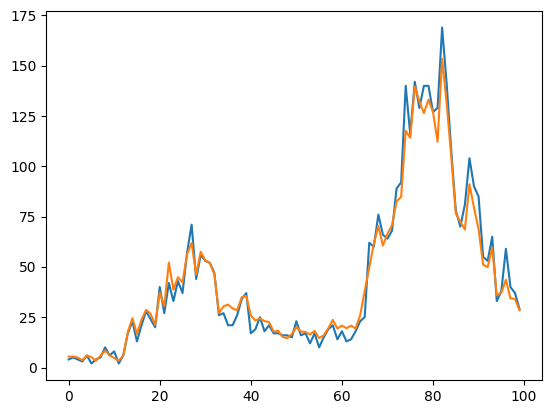

In [26]:
# Change nr to change the scale.
nr = 100
x_line = np.arange(len(y))
plt.plot(x_line[0:nr], y[0:nr], label= "original")
plt.plot(x_line[0:nr], prediction_train[0:nr], label= "prediction")
plt.show()

# Final pipeline with improved features (lag and fourier seasonality)

In [37]:
from statsmodels.tsa.deterministic import (CalendarFourier,
                                           CalendarSeasonality,
                                           CalendarTimeTrend,
                                           DeterministicProcess)

In [104]:
lag_cols = ['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw',
       'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm']

def make_lags(X, columns, lags=8):
    new_dict = {}
    labels = []
    for column in columns:
        for lag in range(1,lags+1):
            #X_new.loc[:, column+'_lag_{}'.format(lag)] = X[column].shift(lag)
            new_dict[column+'_lag_{}'.format(lag)]= X[column].shift(lag)
            labels.append(column+'_lag_{}'.format(lag))

    X_new = pd.DataFrame(new_dict, columns=labels, index=X.index)
    return pd.concat([X, X_new], axis=1)


def get_seasonality(X, time_column='week_start_date', format='%Y-%m-%d'):
    X_new = X.copy()
    X_new[time_column] = pd.to_datetime(X_new[time_column], format=format)
 
    #return_cols = [time_column, 'year', 'month', 'dayofyear', 'weekofyear']
    #X_fourier = X_new[time_column]
    
    fourier_year = CalendarFourier(freq='A', order=5)
    fourier_month = CalendarFourier(freq='M', order=6)
    fourier_week = CalendarFourier(freq='W', order=10)
    fourier_day = CalendarFourier(freq='D', order=3)
    df_year = fourier_year.in_sample(X_new[time_column]).set_index(X_new.index)
    df_month = fourier_month.in_sample(X_new[time_column]).set_index(X_new.index)
    df_week = fourier_week.in_sample(X_new[time_column]).set_index(X_new.index)
    df_day = fourier_day.in_sample(X_new[time_column]).set_index(X_new.index)

    ym = pd.concat([df_year,df_month], axis=1)
    wd = pd.concat([df_week,df_day], axis=1)
    ymwd = pd.concat([ym, wd], axis=1)

    return pd.concat([X_new, ymwd], axis=1)

def preprocess_with_season(X, time_column='week_start_date', format='%Y-%m-%d', lag_cols = lag_cols):
    # Timed features.
    X_new = X.copy()
    X_new[time_column] = pd.to_datetime(X_new[time_column], format=format)
 
    X_new['year'] =  X_new[time_column].apply(lambda x: x.year)
    X_new.loc[:,'month'] = X_new[time_column].apply(lambda x: x.month)
    X_new.loc[:,'dayofyear'] = X_new[time_column].apply(lambda x: x.dayofyear)
    X_new['weekofyear'] =  X_new[time_column].apply(lambda x: x.weekofyear)

    # Add lags
    X_lagged = make_lags(X_new, columns=lag_cols)

    # Add seasonality
    X_seasoned = get_seasonality(X_lagged)

    numerical_cols = list(X_seasoned.select_dtypes(include=[np.number]).columns)
    categorical_cols = list(X_seasoned.select_dtypes(include=[object]).columns)

    # Simple imputer seems to do better than KNNImputer in this case
    numerical_transformer = Pipeline(
        steps =[('imputer', SimpleImputer())]
        )

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])

    return pd.DataFrame(preprocessor.fit_transform(X_seasoned), columns=numerical_cols + ['iq', 'sj'])
    
   

In [105]:
data, X, y = get_train_data(features_dir, labels_dir)

X_preprocessed_season = preprocess_with_season(X, time_column='week_start_date', format='%Y-%m-%d', lag_cols = lag_cols)

model_season = xgb.XGBRegressor(max_depth=5,
                     learning_rate=0.1,
                     n_estimators=100,n_jobs=-1)

xgb_reg_season = model_season.fit(X_preprocessed_season, y)

prediction_train_season =  xgb_reg_season.predict(X_preprocessed_season)
score = mean_absolute_error(y,prediction_train_season)
print("Score: {}".format(score))

X_test = pd.read_csv(test_dir)
X_test_preprocessed_season = preprocess_with_season(X_test)

results_season = xgb_reg_season.predict(X_test_preprocessed_season)
out_df_season = get_test_output(X_test, results_season, indexes = ['city', 'year', 'weekofyear'], file_dir = "weeks_fourier_seasoned_output.csv")


Loading of training data finished.



/home/cristina/miniconda3/envs/dsr-project/lib/python3.12/site-packages/statsmodels/tsa/deterministic.py:569: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)
/home/cristina/miniconda3/envs/dsr-project/lib/python3.12/site-packages/statsmodels/tsa/deterministic.py:569: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)


Score: 2.446557333332149
Saved predictions in competition file format in path weeks_fourier_seasoned_output.csv . /n




/home/cristina/miniconda3/envs/dsr-project/lib/python3.12/site-packages/statsmodels/tsa/deterministic.py:569: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)
/home/cristina/miniconda3/envs/dsr-project/lib/python3.12/site-packages/statsmodels/tsa/deterministic.py:569: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)


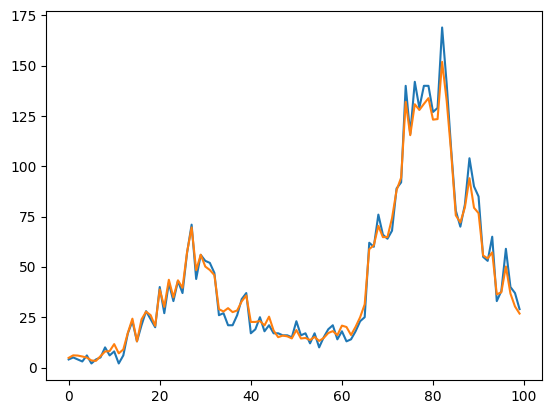

In [106]:
nr = 100
x_line = np.arange(len(y))
plt.plot(x_line[0:nr], y[0:nr], label= "original")
plt.plot(x_line[0:nr], prediction_train_season[0:nr], label= "prediction")
plt.show()

In [70]:
X_preprocessed_season

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,"sin(7,freq=D)","cos(7,freq=D)","sin(8,freq=D)","cos(8,freq=D)","sin(9,freq=D)","cos(9,freq=D)","sin(10,freq=D)","cos(10,freq=D)",iq,sj
0,1990.0,18.0,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
1,1990.0,19.0,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
2,1990.0,20.0,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
3,1990.0,21.0,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
4,1990.0,22.0,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,2010.0,21.0,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,300.771429,296.825714,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
1452,2010.0,22.0,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,299.392857,296.452857,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
1453,2010.0,23.0,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,297.592857,295.501429,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
1454,2010.0,24.0,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,297.521429,295.324286,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0


In [67]:
data, X, y = get_train_data(features_dir, labels_dir)

X_preprocessed_season = preprocess_with_season(X, time_column='week_start_date', format='%Y-%m-%d', lag_cols = lag_cols)


Loading of training data finished.



/home/cristina/miniconda3/envs/dsr-project/lib/python3.12/site-packages/statsmodels/tsa/deterministic.py:569: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)
/home/cristina/miniconda3/envs/dsr-project/lib/python3.12/site-packages/statsmodels/tsa/deterministic.py:569: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)


In [68]:
X_preprocessed_season

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,"sin(7,freq=D)","cos(7,freq=D)","sin(8,freq=D)","cos(8,freq=D)","sin(9,freq=D)","cos(9,freq=D)","sin(10,freq=D)","cos(10,freq=D)",iq,sj
0,1990.0,18.0,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
1,1990.0,19.0,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
2,1990.0,20.0,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
3,1990.0,21.0,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
4,1990.0,22.0,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,2010.0,21.0,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,300.771429,296.825714,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
1452,2010.0,22.0,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,299.392857,296.452857,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
1453,2010.0,23.0,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,297.592857,295.501429,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
1454,2010.0,24.0,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,297.521429,295.324286,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
